In [267]:
%load_ext autoreload
%autoreload 2
import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
df = load_data.load_county_level()
df = df.sort_values(load_data.outcome_deaths, ascending=False)
outcome_cases = load_data.outcome_cases # most recent day
outcome_deaths = load_data.outcome_deaths
deaths_keys = [k for k in df.keys() if '#Deaths' in k]
cases_keys = [k for k in df.keys() if '#Cases' in k]
deaths = df[deaths_keys].values
cases = df[cases_keys].values
df['deaths'] = [deaths[i] for i in range(deaths.shape[0])]
df['cases'] = [cases[i] for i in range(cases.shape[0])]
important_vars = load_data.important_keys(df)

In [269]:
def sum_lists(list_of_lists):
#     print(list_of_lists)
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
    

# aligned plot

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/Users/nick/anaconda2/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



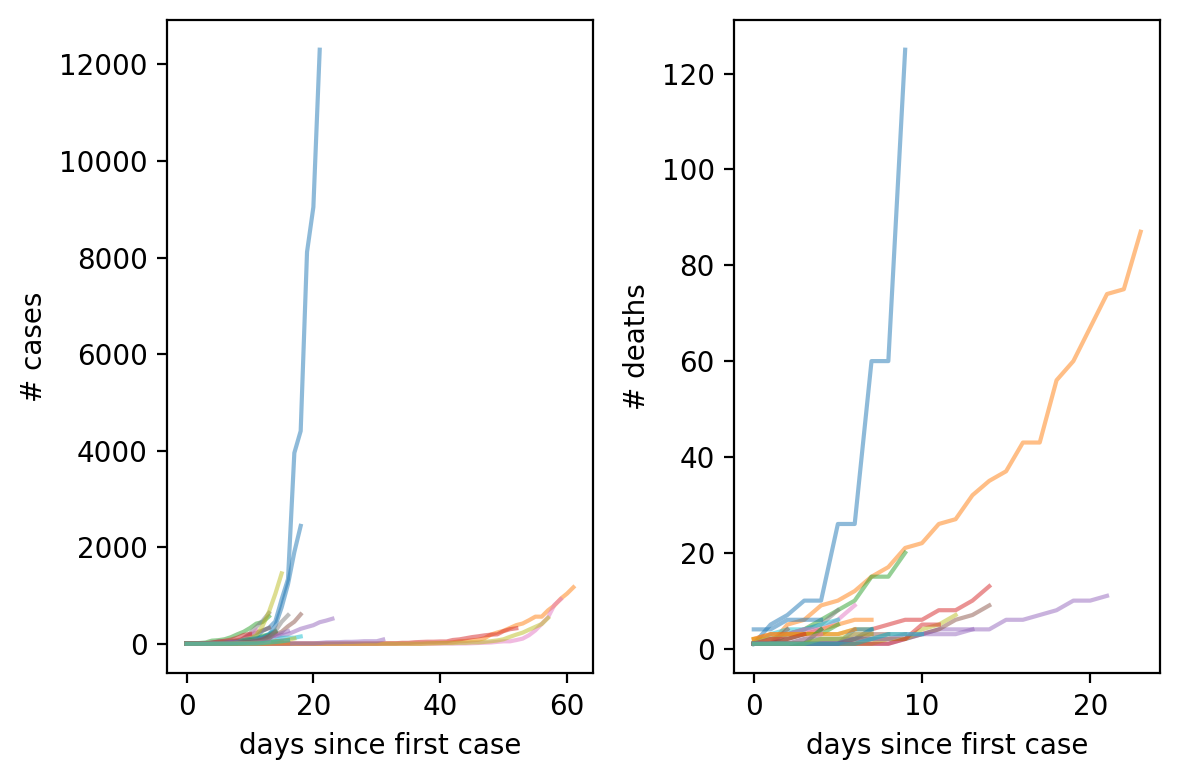

In [270]:
r = df[df[outcome_deaths] > 0]
plt.figure(dpi=200) #dpi=300)
R, C = 1, 2
for i in range(30):
    row = r.iloc[i]
    deaths = [x for x in row['deaths'] if x > 0]
    cases = [x for x in row['cases'] if x > 0]
    plt.subplot(R, C, 1)
    plt.plot(cases, alpha=0.5)
    plt.ylabel('# cases')
    plt.xlabel('days since first case')
    
    plt.subplot(R, C, 2)
    plt.plot(deaths, alpha=0.5)
    plt.ylabel('# deaths')
    plt.xlabel('days since first case')
plt.tight_layout()
plt.show()

In [271]:
# Aggregate by State
state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

42
64
119
507
910
118.61635944700461
16.0


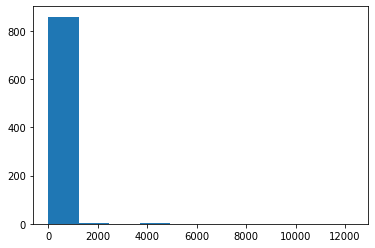

In [252]:
# This is investigating the number of cases associated with non-zero deaths in a county
_deaths = list(df['deaths'])
_cases = list(df['cases'])
total_points = []

cases_for_death = []
for i in range(len(df)):
    for j,d in enumerate(_deaths[i]):
        if d > 0:

            cases_for_death.append(_cases[i][j])
            if _cases[i][j] == 0:
                print(i)
                
plt.hist(cases_for_death)
print(np.mean(cases_for_death))
print(np.quantile(cases_for_death,.5))

1204


(array([1.2e+03, 2.0e+00, 1.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
        0.0e+00, 0.0e+00, 1.0e+00]),
 array([1.00000e+00, 1.23140e+03, 2.46180e+03, 3.69220e+03, 4.92260e+03,
        6.15300e+03, 7.38340e+03, 8.61380e+03, 9.84420e+03, 1.10746e+04,
        1.23050e+04]),
 <a list of 10 Patch objects>)

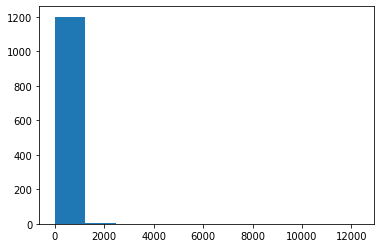

In [253]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))
    
print(sum([v >0 for v in max_cases]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_cases if v > 0])


In [254]:
np.quantile(max_cases,1)

12305

### Clean data

In [255]:
# Remove rows with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
df_with_cases = df[df['max_cases'] > 0]


In [256]:
# Shuffle data
shuffled_df = df_with_cases.sample(frac=1)
# Break into train test (random k-fold cross val on the training set is done to pick hyperparams)
train_ratio, val_ratio, test_ratio = .75,0,.25


train_df = shuffled_df[0:int(train_ratio*len(shuffled_df))]
# val_df = shuffled_df[int(train_ratio*len(shuffled_df)):int(val_ratio*len(shuffled_df))+int(train_ratio*len(shuffled_df))]
test_df = shuffled_df[int(train_ratio*len(shuffled_df))+int(val_ratio*len(shuffled_df)):]



In [258]:
def make_auto_regressive_dataset(df,autoreg_window,log=True,deaths=True,cases=False):
    """
    Make an autoregressive dataset that takes in a dataframe and a history window to predict number of deaths
    for a given day given a history of autoreg_window days before it
    log: take logarithm of values for features and predictions
    deaths: use number of previous deaths as features
    cases: use number of previous cases as features
    """

    assert (deaths == True or cases == True)
    feature_array = []
    ys = []
    _cases = list(df['cases'])
    _deaths = list(df['deaths'])
    for i in range(len(_cases)):
        for j in range(len(_cases[i])-(autoreg_window+1)):
            if sum(_deaths[i][j:j+autoreg_window+1]) > 0:
                cases_window = _cases[i][j:j+autoreg_window]
                if log:
                    cases_window = [np.log(v+1) for v in cases_window ]
                deaths_window = _deaths[i][j:j+autoreg_window]
                if log:
                    deaths_window = [np.log(v+1) for v in deaths_window]
                y_val = _deaths[i][j+autoreg_window+1]
                if log:
                    y_val = np.log(y_val+1)
                features = []
                if deaths == True:
                    features.extend(deaths_window)
                if cases == True:
                    features.extend(cases_window)
                feature_array.append(features)
                ys.append(y_val)
    return feature_array, ys
            
    

In [259]:
def evaluate_model(model,eval_pair, metric, exponentiate=False):
    """
    Model: sklearn model
    Eval pair: (x,y)
    metric: sklearn metric
    exponentiate: exponentiate model predictions?
    """
    predictions = model.predict(eval_pair[0])
    y_val = eval_pair[1]
    if exponentiate:
        predictions = [np.exp(p) for p in predictions]
        y_val = [np.exp(y) for y in y_val]
    return predictions, metric(predictions,y_val)
    


    
    

In [260]:
model = sklearn.neighbors.KNeighborsRegressor()
param_dist ={
    'n_neighbors': [2,4,8,16],
    'weights': ['uniform','distance'],
    'p': [1,2,4]
}

# model = RandomForestRegressor()
# param_dist ={
#     'n_estimators': [50,100,200,400,1000]
# }
# Number of randomly sampled hyperparams
n_iter = 20
metric = sklearn.metrics.mean_squared_error
# n_jobs = number of cores to parallelize across
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter,n_jobs = 8)



auto_reg_windows = [1,2,4,8]
best_window = None
best_loss = None
for w in auto_reg_windows:
    log = False
    x_train, y_train = make_auto_regressive_dataset(train_df,w,log=log)
    x_test, y_test = make_auto_regressive_dataset(test_df,w,log=log)
    random_search.fit(x_train,y_train)
    window_loss = random_search.best_score_
    if best_loss is None:
        best_window = w
        best_loss = window_loss
    elif window_loss < best_loss:
        best_window = w
        best_score = loss
   


x_train, y_train = make_auto_regressive_dataset(train_df,best_window,log=log)
x_test, y_test = make_auto_regressive_dataset(test_df,best_window,log=log)
random_search.fit(x_train,y_train)


preds, loss = evaluate_model(random_search,(x_test,y_test),metric,exponentiate=True)
     
        

# model.fit(x_train,y_train)

In [261]:
random_search.best_params_

{'weights': 'uniform', 'p': 1, 'n_neighbors': 16}

In [262]:
best_window

1

In [263]:
loss

540910.0322576679

In [264]:
# WARNING: does not yet supported number of previous cases as feature
def get_auto_reg_predictions(model,row,window,teacher_forcing=True,exponentiate=False):
    deaths = row['deaths']
    predictions = [0]
    if teacher_forcing:
        for i in range(len(deaths)-(window)):
            x = deaths[i:i+window]
            cur_prediction = model.predict([x])
            if exponentiate:
                cur_prediction = np.exp(cur_prediction)
            predictions.append(cur_prediction)
    else:
        raise NotImplementedError
    return predictions
    
def plot_prediction(model,row,window,exponentiate=False):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    plt.plot(row['deaths'], label='deaths')
    model_predictions = get_auto_reg_predictions(model,row,window,exponentiate)
    print(model_predictions)
    plt.plot(model_predictions,label='predictions')
    plt.legend()
    plt.show()
    
    
    
    
    

[0, array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.5]), array([1.5]), array([2.125]), array([2.875]), array([4.75]), array([7.8125])]


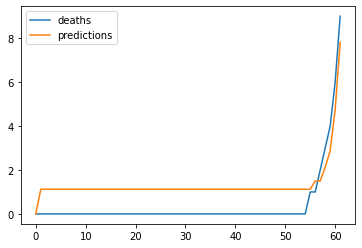

[0, array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.5]), array([1.5]), array([1.5]), array([1.5]), array([1.5]), array([1.5]), array([1.5]), array([2.125]), array([2.125]), array([2.125]), array([2.875]), array([4.75]), array([7.8125]), array([9.5])]


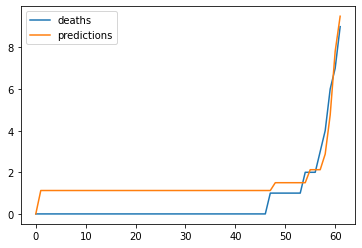

[0, array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([1.125]), array([4.75]), array([4.75]), array([7.8125]), array([7.8125])]


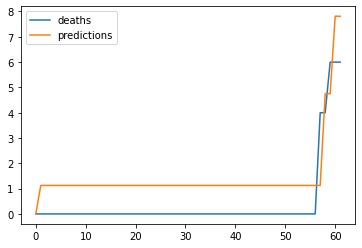

In [266]:

for i in range(len(test_df)):
    row = test_df.iloc[i]
    if max(row['deaths'][:-1]) > 5:
        plot_prediction(random_search,row,best_window,exponentiate=True)

In [ ]:
print 

In [ ]:
row = df.iloc[0]

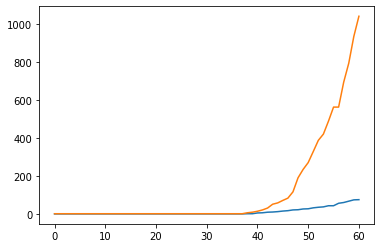

In [ ]:
plt.plot(row['deaths'], label='deaths')
plt.plot(row['cases'], label='cases')
plt.legend()
plt.show()

# visualize counties with most deaths

In [ ]:
df_tab = df[[outcome_deaths, outcome_cases, 'CountyName', 'StateName', 
             'PopulationDensityperSqMile2010',
             'deaths', 'cases']].head(12)        
# df_tab = df_tab.rename(columns={'PopulationEstimate2018': 'Population\n(thousands})'})
df_tab = df_tab.rename(columns={'PopulationDensityperSqMile2010': 'PopDensity'})
df_tab = df_tab.rename(columns={outcome_deaths: '#Deaths', outcome_cases: '#Cases'})
df_tab = df_tab.rename(columns={'CountyName': 'County', 'StateName': 'State'})
print(df_tab.keys())
# df_tab['Population']
keys_table = [k for k in df_tab.keys() if not k in ['deaths', 'cases']]
viz.viz_curves(df_tab, 
               key_toggle='County',
               keys_table=keys_table,
               filename='results/county_curves.html')
print('done!')